#### <b>Download the Original Datasets</b>

* <b>CelebA-HQ Dataset</b>: A dataset consisting of 30,000 "human face" images.
    * This dataset has approximately 3GB of data in size and is one of the most widely used face datasets worldwide.
* <b>CelebA-HQ Identity Dataset</b>: A dataset that provides information about <b>who the individuals (subjects) are</b> for each facial image file.
* <b>CelebA-HQ Attribute Dataset</b>: A dataset that provides attribute information for each facial image file.
    * This attribute information includes <b>gender</b>, <b>smiling</b>, and <b>age</b>, which we will be used for a multi-label task.

In [2]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb37jNPPA7hHl0fmktYqcV8B-qmPLx-ZKYQ1eFk4UPBV_A?download=1 -O CelebAMask-HQ.zip
!wget https://postechackr-my.sharepoint.com/:t:/g/personal/dongbinna_postech_ac_kr/EVRoUY8_txRFv56-KWvZrksBDWbD6adkjBxwwRN7qAC6bg?download=1 -O CelebA-HQ-identity.txt
!wget https://postechackr-my.sharepoint.com/:t:/g/personal/dongbinna_postech_ac_kr/EVrdIrPOkR1OlEWBVK8lE3AB9bFh741GnKBkNgPa8trNuA?download=1 -O CelebA-HQ-attribute.txt

--2023-11-03 14:54:44--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb37jNPPA7hHl0fmktYqcV8B-qmPLx-ZKYQ1eFk4UPBV_A?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/datasets/CelebAMask-HQ/CelebAMask-HQ.zip?ga=1 [following]
--2023-11-03 14:54:45--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/datasets/CelebAMask-HQ/CelebAMask-HQ.zip?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 3153930546 (2.9G) [application/x-zip-compressed]
Saving to: ‘CelebAMask-HQ.zip’

CelebAMask-HQ.zip   100%[===================>]   2.94G  54.4MB/s    in

In [3]:
%%capture
!rm -rf ./CelebAMask-HQ
!unzip CelebAMask-HQ.zip

#### <b>Load Libraries</b>

* Load various useful python libraries for the experiments.

In [4]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection

#### <b>Load Identity Mapping</b>
* Check which person each file name is associated with.
* There are a total of 6,217 individuals (subjects) among the 30,000 files.

In [5]:
path = "./"

In [6]:
identities = {}

# (Image File Name, Subject Identity Information)
with open(path + 'CelebA-HQ-identity.txt') as f:
    lines = f.readlines()
    for line in lines:
        file_name, identity = line.strip().split()
        identities[file_name] = identity

print(f'There are {len(set(identities.values()))} identities.')
print(f'There are {len(identities.keys())} images.')

There are 6217 identities.
There are 30000 images.


In [7]:
attribute_path = path + 'CelebA-HQ-attribute.txt'

# Create a dictionary for mapping attributes.
attributes_map = {
    "gender": 21,
    "smiling": 32,
    "young": 40
}

# Initialize a dictionary to store the results.
label_map = {}

with open(attribute_path) as f:
    lines = f.readlines()
    for line in lines[2:]:
        splited = line.strip().split()
        file_name = splited[0]
        label_map[file_name] = {attr: int(splited[idx]) for attr, idx in attributes_map.items()}

print(f'There are {len(label_map.keys())} images.')

sample_key = list(label_map.keys())[0]
print(f'Sample labels for {sample_key}: {label_map[sample_key]}')

There are 30000 images.
Sample labels for 0.jpg: {'gender': -1, 'smiling': 1, 'young': 1}


#### <b>Split the Dataset</b>
* <b>Training dataset  $\mathcal{D}_{train}$</b>: 25,933 images.
* <b>Test dataset $\mathcal{D}_{test}$</b>: 2,065 images.
* <b>Unseen dataset $\mathcal{D}_{unseen}$</b>: 2,002 images.

In [8]:
source_root = path + 'CelebAMask-HQ/CelebA-HQ-img/'

train_index = 190
retain_index = 1250
unseen_index = 4855

In [9]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity >= train_index and identity < unseen_index:
                gender = int(label_map[file_name]["gender"])
                if gender == -1: gender = 0
                smiling = int(label_map[file_name]["smiling"])
                if smiling == -1: smiling = 0
                young = int(label_map[file_name]["young"])
                if young == -1: young = 0
                self.labels.append((gender, identity, smiling, young))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        gender = torch.tensor(label[0])
        identity = torch.tensor(label[1])
        smiling = torch.tensor(label[2])
        young = torch.tensor(label[3])

        return image, (gender, identity, smiling, young)

In [10]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []
        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < train_index:
                gender = int(label_map[file_name]["gender"])
                if gender == -1: gender = 0
                smiling = int(label_map[file_name]["smiling"])
                if smiling == -1: smiling = 0
                young = int(label_map[file_name]["young"])
                if young == -1: young = 0
                self.labels.append((gender, identity, smiling,  young))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        gender = torch.tensor(label[0])
        identity = torch.tensor(label[1])
        smiling = torch.tensor(label[2])
        young = torch.tensor(label[3])

        return image, (gender, identity, smiling, young)

In [11]:
class ForgetDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity >= train_index and identity < retain_index:
                gender = int(label_map[file_name]["gender"])
                if gender == -1: gender = 0
                smiling = int(label_map[file_name]["smiling"])
                if smiling == -1: smiling = 0
                young = int(label_map[file_name]["young"])
                if young == -1: young = 0
                self.labels.append((gender, identity, smiling, young))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        gender = torch.tensor(label[0])
        identity = torch.tensor(label[1])
        smiling = torch.tensor(label[2])
        young = torch.tensor(label[3])

        return image, (gender, identity, smiling, young)

In [12]:
class RetainDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < unseen_index and identity >= retain_index:
                gender = int(label_map[file_name]["gender"])
                if gender == -1: gender = 0
                smiling = int(label_map[file_name]["smiling"])
                if smiling == -1: smiling = 0
                young = int(label_map[file_name]["young"])
                if young == -1: young = 0
                self.labels.append((gender, identity, smiling, young))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        gender = torch.tensor(label[0])
        identity = torch.tensor(label[1])
        smiling = torch.tensor(label[2])
        young = torch.tensor(label[3])

        return image, (gender, identity, smiling, young)

In [13]:
class UnseenDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []
        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < unseen_index:
                continue
            gender = int(label_map[file_name]["gender"])
            if gender == -1: gender = 0
            smiling = int(label_map[file_name]["smiling"])
            if smiling == -1: smiling = 0
            young = int(label_map[file_name]["young"])
            if young == -1: young = 0
            self.labels.append((gender, identity, smiling, young))
            self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        gender = torch.tensor(label[0])
        identity = torch.tensor(label[1])
        smiling = torch.tensor(label[2])
        young = torch.tensor(label[3])

        return image, (gender, identity, smiling, young)

In [14]:
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_set = TrainDataset(transform=train_transform)
test_set = TestDataset(transform=test_transform)
forget_set_train = ForgetDataset(transform=train_transform)
forget_set_test = ForgetDataset(transform=test_transform)
retain_set_train = RetainDataset(transform=train_transform)
retain_set_test = RetainDataset(transform=test_transform)
unseen_set = UnseenDataset(transform=unseen_transform)

In [15]:
print('Train dataset size:', len(train_set))
print('Test dataset size:', len(test_set))
print('Forget dataset size:', len(forget_set_train))
print('Retain dataset size:', len(retain_set_train))
print('Unseen dataset size:', len(unseen_set))

Train dataset size: 25933
Test dataset size: 2065
Forget dataset size: 10183
Retain dataset size: 15750
Unseen dataset size: 2002



* In the NeurIPS Competition setting, when performing machine unlearning, training is done with 'retain' and 'forget', so augmentation can be applied. However, it should never be applied during evaluation.

In [16]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
forget_dataloader_train = torch.utils.data.DataLoader(forget_set_train, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
forget_dataloader_test = torch.utils.data.DataLoader(forget_set_test, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
retain_dataloader_train = torch.utils.data.DataLoader(retain_set_train, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
retain_dataloader_test = torch.utils.data.DataLoader(retain_set_test, batch_size=64, shuffle=False, num_workers=2,pin_memory=True)
unseen_dataloader = torch.utils.data.DataLoader(unseen_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [17]:
train_image_paths = TrainDataset().image_paths
test_image_paths = TestDataset().image_paths
forget_image_paths = ForgetDataset().image_paths
retain_image_paths = RetainDataset().image_paths
unseen_image_paths = UnseenDataset().image_paths

train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retain_overlap = len(set(train_image_paths) & set(retain_image_paths))
train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
test_retain_overlap = len(set(test_image_paths) & set(retain_image_paths))
test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
forget_retain_overlap = len(set(forget_image_paths) & set(retain_image_paths))
forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
retain_unseen_overlap = len(set(retain_image_paths) & set(unseen_image_paths))

overlap_dict = {
    'train_test': train_test_overlap,
    'train_forget': train_forget_overlap,
    'train_retain': train_retain_overlap,
    'train_unseen': train_unseen_overlap,
    'test_forget': test_forget_overlap,
    'test_retain': test_retain_overlap,
    'test_unseen': test_unseen_overlap,
    'forget_retain': forget_retain_overlap,
    'forget_unseen': forget_unseen_overlap,
    'retain_unseen': retain_unseen_overlap
}
overlap_dict

{'train_test': 0,
 'train_forget': 10183,
 'train_retain': 15750,
 'train_unseen': 0,
 'test_forget': 0,
 'test_retain': 0,
 'test_unseen': 0,
 'forget_retain': 0,
 'forget_unseen': 0,
 'retain_unseen': 0}

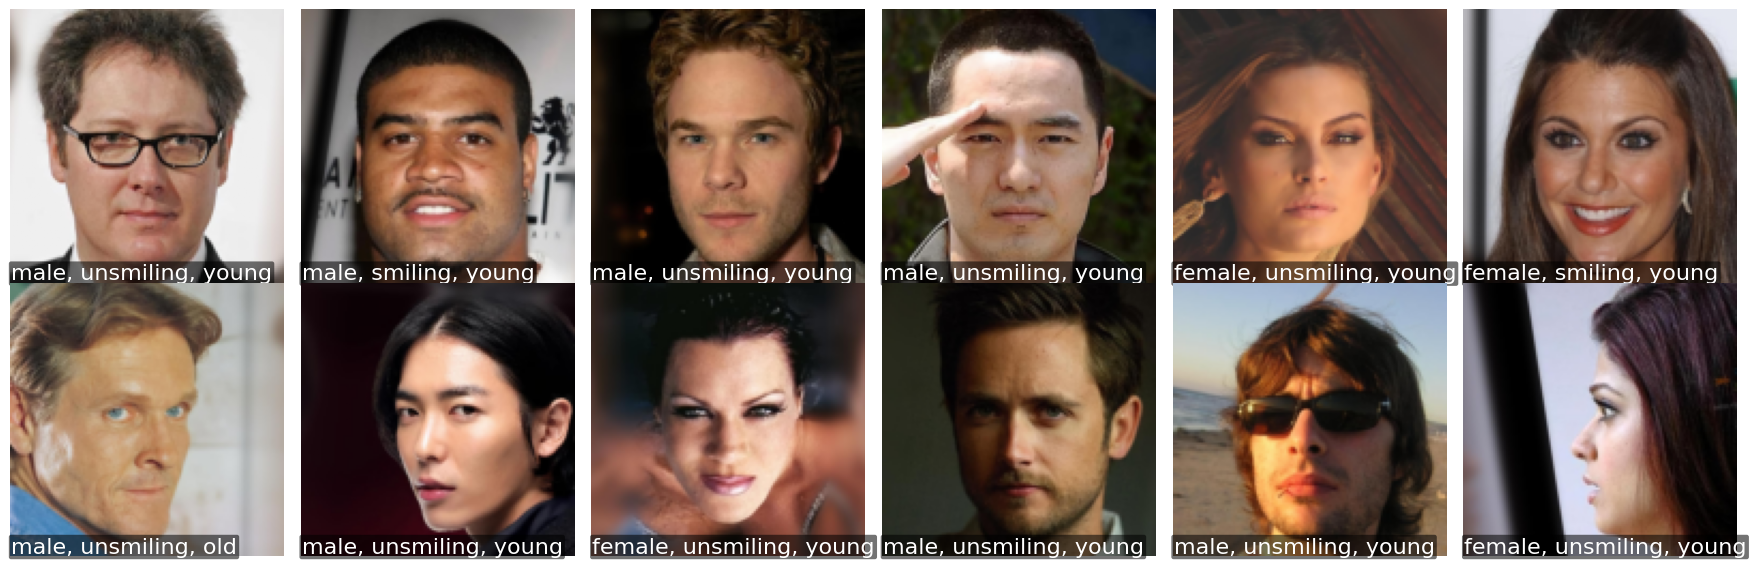

In [18]:
def label_to_string(gender, smiling, young):
    gender_str = "male" if gender == 1 else "female"
    smiling_str = "smiling" if smiling == 1 else "unsmiling"
    young_str = "young" if young == 1 else "old"
    return f"{gender_str}, {smiling_str}, {young_str}"

def show_images(images, labels, nrow=6, save_path = None):
    n_images = 12
    images = images[:12]
    labels = labels[:12]
    nrows = (n_images + nrow - 1) // nrow

    # Create a grid of subplots
    fig, axs = plt.subplots(nrows, nrow, figsize=(22.5, 7.1))
    axs = axs.ravel()  # Flatten the array of axes
    plt.subplots_adjust(wspace=0, hspace=0)

    for i in range(n_images):
        img = images[i].numpy().transpose((1, 2, 0))
        label_str = label_to_string(labels[0][i].item(), labels[2][i].item(), labels[3][i].item())
        axs[i].imshow(img)
        axs[i].axis('off')

        axs[i].text(0, img.shape[0], label_str, color='white', fontsize=16,
                    ha='left', va='bottom',
                    bbox=dict(facecolor='black', alpha=0.55, edgecolor='none', boxstyle='round,pad=0.1'))
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

images, labels = next(iter(unseen_dataloader))
show_images(images, labels, nrow=6)

#### <b>Train the "Original Model"</b>

* Train the Original model to serve as the base model for performing Machine Unlearning

In [19]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [20]:
# Define a custom head for the multi-label classification.
class MultiLabelHead(nn.Module):
    def __init__(self, in_features, out_features):
        super(MultiLabelHead, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.fc(x)

In [21]:
original_model = models.resnet18(pretrained=False)
num_features = original_model.fc.in_features

# For 3 binary classifications (gender, smiling, age).
original_model.fc = MultiLabelHead(num_features, 3)
original_model = original_model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [22]:
def train(model, dataloader):
    set_seed(42)

    model.train()
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')

    running_loss = 0.
    running_corrects = 0
    running_corrects_gender = 0
    running_corrects_smiling = 0
    running_corrects_young = 0

    print_every = 20
    batch_losses = []

    # Load a batch data of images.
    for i, (inputs, (gender, identity, smiling, young)) in enumerate(dataloader):
        inputs = inputs.cuda()

        # Convert labels to the same format as the outputs (float).
        labels = torch.stack((gender, smiling, young), dim=1).type(torch.FloatTensor).cuda()

        # Forward inputs and get output.
        optimizer.zero_grad()
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)

        loss = criterion(outputs, labels)
        batch_losses.append(loss.item())

        # Get loss value and update the network weights.
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy for the current batch.
        threshold = 0.5
        preds = (probs > threshold).int()
        corrects = torch.sum(preds == labels.int()).item()
        running_corrects += corrects

        # Calculate accuracy for each label in the current batch.
        corrects_gender = torch.sum(preds[:, 0] == gender.int().to(device)).item()
        corrects_smiling = torch.sum(preds[:, 1] == smiling.int().to(device)).item()
        corrects_young = torch.sum(preds[:, 2] == young.int().to(device)).item()
        running_corrects_gender += corrects_gender
        running_corrects_smiling += corrects_smiling
        running_corrects_young += corrects_young

        # Print average loss for the last 'print_every' batches.
        if (i + 1) % print_every == 0:
            avg_loss = sum(batch_losses) / print_every
            print(f"[Batch {i+1}] Avg. Loss: {avg_loss:.4f}")
            batch_losses = []

    # Calculate average training accuracy.
    acc_avg = running_corrects / (len(dataloader.dataset) * 3)

    # Calculate average accuracy for each label.
    acc_gender = running_corrects_gender / len(dataloader.dataset)
    acc_smiling = running_corrects_smiling / len(dataloader.dataset)
    acc_young = running_corrects_young / len(dataloader.dataset)

    loss = running_loss / len(train_set)
    print('[Train] Loss: {:.4f}, Average Training Accuracy: {:.2f}, '
          'Gender Acc: {:.2f}, Smiling Acc: {:.2f}, Young Acc: {:.2f}, Time: {:.4f}s'.format(
        loss, acc_avg, acc_gender, acc_smiling, acc_young, time.time() - start_time))

    return loss, (acc_avg, acc_gender, acc_smiling, acc_young)

In [23]:
def test(model, dataloader):

    start_time = time.time()
    print(f'[Test]')
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        total_corrects_gender = 0
        total_corrects_smiling = 0
        total_corrects_young = 0

        for inputs, (gender, identity, smiling, young) in dataloader:
            inputs = inputs.cuda()

            # Convert labels to the same format as the outputs (float)
            labels = torch.stack((gender, smiling, young), dim=1).type(torch.FloatTensor).cuda()

            outputs = model(inputs)
            probs = torch.sigmoid(outputs)

            loss = criterion(outputs, labels)

            # Calculate accuracy for each label
            threshold = 0.5
            preds = (probs > threshold).int()
            total_corrects_gender += torch.sum(preds[:, 0] == gender.cuda())
            total_corrects_smiling += torch.sum(preds[:, 1] == smiling.cuda())
            total_corrects_young += torch.sum(preds[:, 2] == young.cuda())

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(test_set)
        acc_gender = total_corrects_gender.item() / len(test_set)
        acc_smiling = total_corrects_smiling.item() / len(test_set)
        acc_young = total_corrects_young.item() / len(test_set)
        acc_avg = (acc_gender + acc_smiling + acc_young) / 3.0

        print('Loss: {:.4f} Time: {:.4f}s'.format(epoch_loss, time.time() - start_time))
        print('Average Accuracy: {:.2f} | Gender Acc: {:.2f} | Smiling Acc: {:.2f} | Young Acc: {:.2f}'.format(
            acc_avg, acc_gender, acc_smiling, acc_young
        ))

        return epoch_loss, (acc_avg, acc_gender, acc_smiling, acc_young)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
set_seed(42)

num_original_epochs = 8
criterion = nn.BCEWithLogitsLoss()
learning_rate= 0.01
optimizer = optim.SGD(original_model.parameters(), lr=learning_rate)

history = []
accuracy = {'gender': [], 'smiling': [], 'young': []}
best_test_acc = 0
best_test_acc_avg = 0.0
best_epoch = 0

for epoch in range(num_original_epochs):

    # Train the model and get training loss and accuracy
    train_loss, train_acc = train(original_model, train_dataloader)
    train_acc_avg, train_acc_gender, train_acc_smiling, train_acc_young = train_acc

    # Test the model and get test loss and accuracy for each label
    test_loss, test_acc = test(original_model, test_dataloader)
    test_acc_avg, test_acc_gender, test_acc_smiling, test_acc_young = test_acc

    history.append((train_loss, test_loss))
    accuracy['gender'].append((train_acc_gender, test_acc_gender))
    accuracy['smiling'].append((train_acc_smiling, test_acc_smiling))
    accuracy['young'].append((train_acc_young, test_acc_young))

    if test_acc_avg > best_test_acc_avg:
        print("[Info] best test accuracy!")
        best_test_acc_avg = test_acc_avg
        best_epoch = epoch
        torch.save(original_model.state_dict(), f'best_checkpoint_epoch_{epoch + 1}_multi_label.pth')

# Save the model at the last epoch
torch.save(original_model.state_dict(), f'last_checkpoint_epoch_{num_original_epochs}_multi_label.pth')

In [ ]:
import matplotlib.pyplot as plt

# Extract training and testing loss from history
train_losses, test_losses = zip(*history)

# Extract training and testing accuracy for each label
train_gender_acc, test_gender_acc = zip(*accuracy['gender'])
train_smiling_acc, test_smiling_acc = zip(*accuracy['smiling'])
train_young_acc, test_young_acc = zip(*accuracy['young'])

# Create a list of epoch numbers for x-axis
epochs = range(1, num_original_epochs + 1)

# Plot training and testing loss
plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Plot training and testing accuracy for each label
plt.subplot(1, 2, 2)
plt.plot(epochs, train_gender_acc, label='Train Gender Acc', color='blue')
plt.plot(epochs, test_gender_acc, label='Test Gender Acc', linestyle='dashed', color='blue')
plt.plot(epochs, train_smiling_acc, label='Train Smiling Acc',color='green')
plt.plot(epochs, test_smiling_acc, label='Test Smiling Acc', linestyle='dashed', color='green')
plt.plot(epochs, train_young_acc, label='Train Young Acc',color='red')
plt.plot(epochs, test_young_acc, label='Test Young Acc', linestyle='dashed', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()

#### <b>(Option) Load the Pre-trained Original Model</b>

* We can easily download the pre-trained original model, rather than training the original model from scratch.
* <b>Download Link</b>: https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebdiwb9ujSNFvciQumF9dJUBXrEgBOB4xiZrdp4YmLpMyw

In [28]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebdiwb9ujSNFvciQumF9dJUBXrEgBOB4xiZrdp4YmLpMyw?download=1 -O pre_trained_last_checkpoint_epoch_8.pth

--2023-11-03 15:02:03--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebdiwb9ujSNFvciQumF9dJUBXrEgBOB4xiZrdp4YmLpMyw?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/Machine%20Unlearning/last_checkpoint_epoch_8.pth?ga=1 [following]
--2023-11-03 15:02:13--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/Machine%20Unlearning/last_checkpoint_epoch_8.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 44771195 (43M) [application/octet-stream]
Saving to: ‘pre_trained_last_checkpoint_epoch_8.pth’

pre_trained_last_ch 100%[

<b>Final Test</b>

In [30]:
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = MultiLabelHead(num_features, 3)
model = model.cuda()
# model_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
model_path = f'pre_trained_last_checkpoint_epoch_8.pth'
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = test(model, test_dataloader)
print("test loss:", test_loss)
print("test acc:", test_acc)

[Test]
Loss: 0.2678 Time: 22.1505s
Average Accuracy: 0.89 | Gender Acc: 0.91 | Smiling Acc: 0.91 | Young Acc: 0.83
test loss: 0.2677946607368044
test acc: (0.8852300242130751, 0.9138014527845036, 0.914769975786925, 0.8271186440677966)


#### <b> Train the "Retrained Model"</b>
* A model trained on only the retain dataset from scratch, excluding the forget dataset.
* This model can serve as a proxy ground-truth for calculating the potential ground-truth (1) model utility and (2) forgetting score.

In [32]:
@torch.no_grad()
def evaluation(model, data_loader):
    model.eval()

    running_loss_gender = 0.
    running_corrects_gender = 0

    running_loss_smiling = 0.
    running_corrects_smiling = 0

    running_loss_young = 0.
    running_corrects_young = 0

    for inputs, (gender, identity, smiling, young) in data_loader:
        inputs = inputs.cuda()
        gender = gender.cuda()
        smiling = smiling.cuda()
        young = young.cuda()

        outputs = model(inputs)

        probs = torch.sigmoid(outputs)
        outputs_gender = probs[:, 0]
        outputs_smiling = probs[:, 1]
        outputs_young = probs[:, 2]

        preds_gender = (outputs_gender > 0.5).long()
        preds_smiling = (outputs_smiling > 0.5).long()
        preds_young = (outputs_young > 0.5).long()

        running_corrects_gender += torch.sum(preds_gender == gender)
        running_corrects_smiling += torch.sum(preds_smiling == smiling)
        running_corrects_young += torch.sum(preds_young == young)

    epoch_acc_gender = running_corrects_gender.item() / len(data_loader.dataset)
    epoch_acc_smiling = running_corrects_smiling.item() / len(data_loader.dataset)
    epoch_acc_young = running_corrects_young.item() / len(data_loader.dataset)

    avg_accuracy = (epoch_acc_gender + epoch_acc_smiling + epoch_acc_young) / 3

    return {
        'Average Acc': avg_accuracy,
        'Gender Acc': epoch_acc_gender,
        'Smiling Acc': epoch_acc_smiling,
        'Young Acc': epoch_acc_young,
    }

In [33]:
def compute_losses(net, loader):
    criterion = nn.BCEWithLogitsLoss(reduction="none")
    all_losses = []

    for inputs, (gender, identity, smiling, young) in loader:
        labels = torch.stack((gender, smiling,  young), dim=1).type(torch.FloatTensor)
        inputs, labels = inputs.cuda(), labels.cuda()

        logits = net(inputs)

        losses = criterion(logits, labels).mean(dim=1).cpu().detach().numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

def cal_mia(model):
    set_seed(42)

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}

<b>Original Model Preformance</b>

In [ ]:
unlearned_model = models.resnet18(pretrained=False)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = MultiLabelHead(num_features, 3)
unlearned_model = unlearned_model.cuda()
# model_path = f'last_checkpoint_epoch_{num_original_epochs}_multi_label.pth' # If you trian the original model from scratch.
model_path = f'pre_trained_last_checkpoint_epoch_8.pth'
unlearned_model.load_state_dict(torch.load(model_path))

# Performance
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)
mia = cal_mia(unlearned_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Average Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Acc: {'Average Acc': 0.8852300242130751, 'Gender Acc': 0.9138014527845036, 'Smiling Acc': 0.914769975786925, 'Young Acc': 0.8271186440677966}
Unseen Acc: {'Average Acc': 0.8344988344988344, 'Gender Acc': 0.9105894105894106, 'Smiling Acc': 0.8681318681318682, 'Young Acc': 0.7247752247752248}
MIA: {'MIA': 0.556857855361596, 'Forgeting Score': 0.056857855361596044}
Final Score: 0.8857571567449415


In [34]:
retrained_model = models.resnet18(pretrained=False)
num_features = retrained_model.fc.in_features
retrained_model.fc = MultiLabelHead(num_features, 3)
retrained_model = retrained_model.cuda()

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
set_seed(42)

num_original_epochs = 7
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(retrained_model.parameters(), lr=0.01)

history = []
accuracy = {'gender': [], 'smiling': [], 'young': []}

learning_rate = 0.01
best_test_acc_avg = 0.0
best_test_acc = 0
best_epoch = 0

for epoch in range(num_original_epochs):

    # Train the model and get training loss and accuracy
    train_loss, train_acc = train(retrained_model, retain_dataloader_train)
    train_acc_avg, train_acc_gender, train_acc_smiling, train_acc_young = train_acc

    # Test the model and get test loss and accuracy for each label
    test_loss, test_acc = test(retrained_model, test_dataloader)
    test_acc_avg, test_acc_gender, test_acc_smiling, test_acc_young = test_acc

    history.append((train_loss, test_loss))
    accuracy['gender'].append((train_acc_gender, test_acc_gender))
    accuracy['smiling'].append((train_acc_smiling, test_acc_smiling))
    accuracy['young'].append((train_acc_young, test_acc_young))

In [ ]:
import matplotlib.pyplot as plt

# Extract training and testing loss from history
train_losses, test_losses = zip(*history)

# Extract training and testing accuracy for each label
train_gender_acc, test_gender_acc = zip(*accuracy['gender'])
train_smiling_acc, test_smiling_acc = zip(*accuracy['smiling'])
train_young_acc, test_young_acc = zip(*accuracy['young'])

# Create a list of epoch numbers for x-axis
epochs = range(1, num_original_epochs + 1)

# Plot training and testing loss
plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Plot training and testing accuracy for each label
plt.subplot(1, 2, 2)
plt.plot(epochs, train_gender_acc, label='Train Gender Acc', color='blue')
plt.plot(epochs, test_gender_acc, label='Test Gender Acc', linestyle='dashed', color='blue')
plt.plot(epochs, train_smiling_acc, label='Train Smiling Acc',color='green')
plt.plot(epochs, test_smiling_acc, label='Test Smiling Acc', linestyle='dashed', color='green')
plt.plot(epochs, train_young_acc, label='Train Young Acc',color='red')
plt.plot(epochs, test_young_acc, label='Test Young Acc', linestyle='dashed', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()

In [ ]:
# Performance
test_acc = evaluation(retrained_model, test_dataloader)
unseen_acc = evaluation(retrained_model, unseen_dataloader)
mia = cal_mia(retrained_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Average Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Test Acc: {'Average Acc': 0.9031476997578692, 'Gender Acc': 0.9491525423728814, 'Smiling Acc': 0.9075060532687651, 'Young Acc': 0.8527845036319612}
Unseen Acc: {'Average Acc': 0.8606393606393606, 'Gender Acc': 0.935064935064935, 'Smiling Acc': 0.8376623376623377, 'Young Acc': 0.8091908091908092}
MIA: {'MIA': 0.5528678304239402, 'Forgeting Score': 0.052867830423940165}
Final Score: 0.8987060194549945
